In [ ]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [ ]:
# Define constants
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 20

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_path = '/content/drive/MyDrive/Breast Cancer Dataset.zip'


In [ ]:
import zipfile

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content')  # Extract to /content directory in Colab

In [ ]:

# Path to the extracted "data" directory
data_path = '/content/Breast Cancer Dataset'

# Paths to the extracted "normal" and "tumor" directories
normal_path = os.path.join(data_path, 'normal')
tumor_path = os.path.join(data_path, 'tumor')

# Check if the directories exist
print("Normal directory exists:", os.path.isdir(normal_path))
print("Tumor directory exists:", os.path.isdir(tumor_path))

Normal directory exists: True
Tumor directory exists: True


In [ ]:
# Get the current working directory
current_directory = os.getcwd()

# Print the current working directory
print("Current working directory:", current_directory)

Current working directory: /content


In [ ]:
# Check if directories exist
print("Normal directory exists:", os.path.isdir(normal_path))
print("Tumor directory exists:", os.path.isdir(tumor_path))

Normal directory exists: True
Tumor directory exists: True


In [ ]:
import glob
# Load the list of filenames from the directories using glob
normal_filenames = glob.glob(os.path.join(normal_path, '*.png'))  # Adjust the file extension if needed
tumor_filenames = glob.glob(os.path.join(tumor_path, '*.png'))    # Adjust the file extension if needed


In [ ]:
len(normal_filenames)

547

In [ ]:
len(tumor_filenames)

1146

In [ ]:
# Combine the filenames and create labels
filenames = normal_filenames + tumor_filenames
labels = ['normal'] * len(normal_filenames) + ['tumor'] * len(tumor_filenames)

In [ ]:
# Split the data into training and testing sets
train_filenames, test_filenames, train_labels, test_labels = train_test_split(
    filenames, labels, test_size=0.2, random_state=42, stratify=labels)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# Data generators for training and testing
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

# For training data, use 'subset='training''
train_generator = train_datagen.flow_from_directory(
    data_path,  # Path to the data directory containing 'Normal' and 'Tumor' subdirectories
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training'  # Specify 'training' subset for training data
)

# For validation data, use 'subset='validation'' and same 'train_datagen' as used for training
validation_generator = train_datagen.flow_from_directory(
    data_path,  # Path to the data directory containing 'Normal' and 'Tumor' subdirectories
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # Specify 'validation' subset for validation data
)

# For testing data, use separate 'test_datagen'
test_generator = test_datagen.flow_from_directory(
    data_path,  # Path to the data directory containing 'Normal' and 'Tumor' subdirectories
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)



Found 1355 images belonging to 2 classes.
Found 338 images belonging to 2 classes.
Found 1693 images belonging to 2 classes.


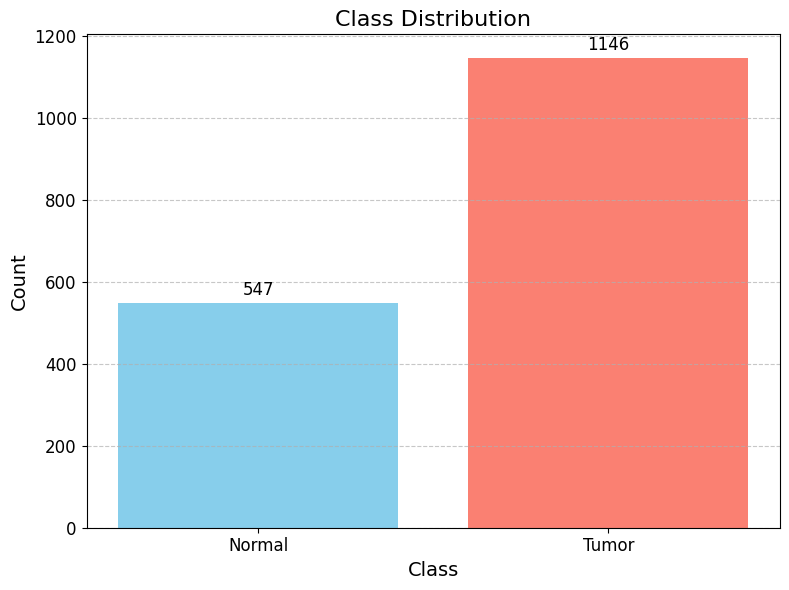

In [ ]:
import matplotlib.pyplot as plt

# Define data
class_labels = ['Normal', 'Tumor']
class_counts = [len(normal_filenames), len(tumor_filenames)]
colors = ['skyblue', 'salmon']

# Create bar chart
plt.figure(figsize=(8, 6))
plt.bar(class_labels, class_counts, color=colors)

# Add data labels
for i, count in enumerate(class_counts):
    plt.text(i, count + 20, str(count), ha='center', fontsize=12)

# Customize plot
plt.xlabel('Class', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Class Distribution', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()


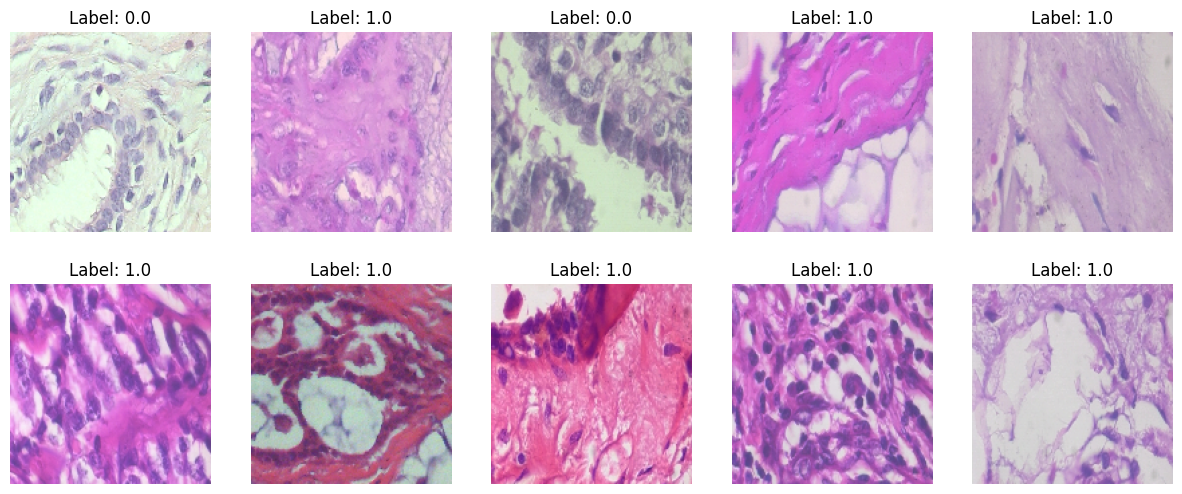

In [ ]:

# Image Visualization
sample_images, sample_labels = train_generator.next()
sample_images = sample_images[:10]  # Select first 10 images
sample_labels = sample_labels[:10]  # Corresponding labels

plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(sample_images[i])
    plt.title('Label: {}'.format(sample_labels[i]))
    plt.axis('off')
plt.show()

In [ ]:
import numpy as np
# Image Statistics
mean_pixel_intensity = np.mean(sample_images)
std_pixel_intensity = np.std(sample_images)

print('Mean Pixel Intensity:', mean_pixel_intensity)
print('Standard Deviation of Pixel Intensity:', std_pixel_intensity)

Mean Pixel Intensity: 0.6984746
Standard Deviation of Pixel Intensity: 0.17385526


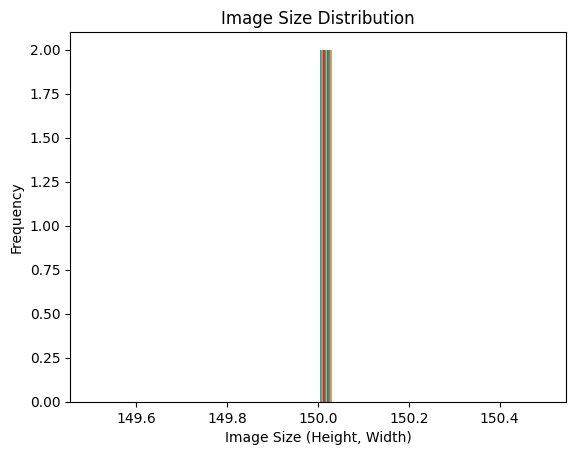

In [ ]:
image_sizes = []
for i in range(len(train_generator)):
    batch_images, _ = train_generator[i]
    for image in batch_images:
        image_sizes.append(image.shape[:2])  # Keep only height and width

# Plot histogram of image sizes
plt.hist(image_sizes, bins=30)
plt.xlabel('Image Size (Height, Width)')
plt.ylabel('Frequency')
plt.title('Image Size Distribution')
plt.show()


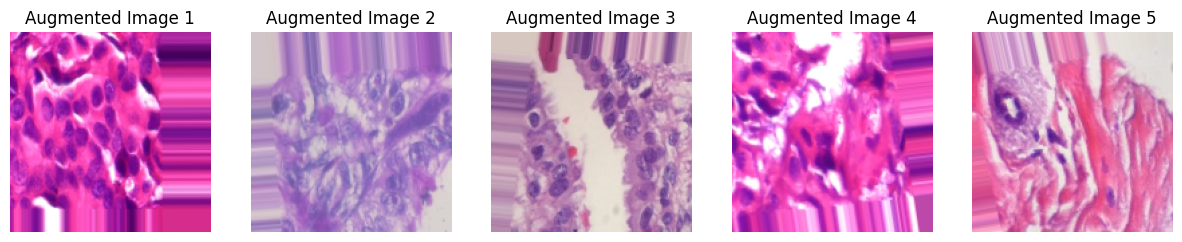

In [ ]:
# Configure data augmentation
data_augmentation = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generate augmented images
augmented_images, _ = next(data_augmentation.flow(train_generator.next(), batch_size=5))

# Plot augmented images
plt.figure(figsize=(15, 6))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(augmented_images[i])
    plt.title('Augmented Image {}'.format(i + 1))
    plt.axis('off')
plt.show()


In [ ]:
# Define the CNN model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [ ]:

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
from keras.callbacks import EarlyStopping
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [ ]:
# Train the model with optimized parameters
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,  # Start with a higher number of epochs
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    batch_size=64,  # Increased batch size
    callbacks=[early_stopping]  # Early stopping
)

Epoch 1/20
43/43 [==============================] - 91s 2s/step - loss: 0.5507 - accuracy: 0.7328 - val_loss: 0.4724 - val_accuracy: 0.7663
Epoch 2/20
43/43 [==============================] - 89s 2s/step - loss: 0.4660 - accuracy: 0.8148 - val_loss: 0.5603 - val_accuracy: 0.7692
Epoch 3/20
43/43 [==============================] - 87s 2s/step - loss: 0.5109 - accuracy: 0.7417 - val_loss: 0.4911 - val_accuracy: 0.7692
Epoch 4/20
43/43 [==============================] - 89s 2s/step - loss: 0.4602 - accuracy: 0.8258 - val_loss: 0.6209 - val_accuracy: 0.6982


In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print('Test accuracy:', test_acc)

53/53 [==============================] - 44s 817ms/step - loss: 0.4441 - accuracy: 0.8163
Test accuracy: 0.8163024187088013


In [ ]:
# Convert decimal accuracy to percentage
accuracy_percentage = test_acc * 100

# Print the accuracy percentage
print('Test accuracy:', accuracy_percentage, '%')


Test accuracy: 81.63024187088013 %


In [ ]:
from keras.models import load_model

# Assuming 'model' is your trained model object
# Replace 'model' with the variable name of your trained model
# Replace 'kidney_model.h5' with the desired filename for your model
model.save('bcd_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:

import os
import pickle
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('bcd_model.h5')

# Save the model using pickle
with open('bcd_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Load the model using pickle
with open('bcd_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)
